<hr style="border:none;height:6px;background:#fff;margin:1em 0;">


<div style="text-align: center;">
  <h1>Dividend Taxation and Top-Income Inequality</h1>
  <h3>HEC Liege</h3>
  <h4><em>Lucas Dubois</em></h4>
</div>

<hr style="border:none;height:6px;background:#fff;margin:1em 0;">


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


In [1038]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
from statsmodels.stats import diagnostic
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.stats.sandwich_covariance import se_cov
from stargazer.stargazer import Stargazer
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
import statsmodels.formula.api as smf
import warnings
import re

path = '/Users/lucasdubois/Desktop/MASTERDATA/' 

<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>1</small>&nbsp;&nbsp;&nbsp;&nbsp;Database:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">








<div style="text-align: align;">
  <h3> <small>1.1</small>&nbsp;&nbsp;&nbsp;&nbsp;Extracting:</h3>
</div>

In order to realize this research, I will construct a database by combining several available databases. Firstly, I will start the database by adding the [WID](https://wid.world/)'s data for top income inequality as well as the top wealth . The [WID](https://wid.world/) provides data for both the 1st and the 10th percentiles, and will have both. This, hopefully, will allow us to obtain various results we can make sense of.

In [1044]:
df1 = pd.read_csv(path + 'WID_income_inequality4.csv', sep=';', skiprows=1, engine='python')
df1.columns = df1.columns.str.strip()

def extract_country(col: str) -> str:
    parts = col.split("\n")
    return parts[-1].strip()

rename_map = {}
for col in df1.columns:
    if isinstance(col, str) and col.startswith("sptinc_z_"):
        rename_map[col] = extract_country(col) + "_inc"
    elif isinstance(col, str) and col.startswith("shweal_z_"):
        rename_map[col] = extract_country(col) + "_w"

df1 = df1.rename(columns=rename_map)

df_long = df1.melt(
    id_vars=['Percentile', 'Year'],
    var_name='CountryVar',
    value_name='Value'
)

tmp = df_long['CountryVar'].str.rsplit('_', n=1, expand=True)
df_long['Country Name'] = tmp[0]
df_long['kind'] = tmp[1]  

df_long = df_long[df_long['Percentile'].isin(['p99p100', 'p90p100'])]

pct_map = {'p99p100': 'top1', 'p90p100': 'top10'}
df_long['var'] = df_long['Percentile'].map(pct_map) + '_' + df_long['kind']

df1 = (df_long
           .pivot_table(index=['Year', 'Country Name'], columns='var', values='Value', aggfunc='mean')
           .reset_index()
           .sort_values(['Country Name', 'Year'])
           .reset_index(drop=True)
           .round(4))

df1.head()

var,Year,Country Name,top10_inc,top10_w,top1_inc,top1_w
0,1980,Afghanistan,0.4095,NaN,0.1583,NaN
1,1981,Afghanistan,0.4095,NaN,0.1583,NaN
2,1982,Afghanistan,0.4095,NaN,0.1583,NaN
3,1983,Afghanistan,0.4095,NaN,0.1583,NaN
4,1984,Afghanistan,0.4095,NaN,0.1583,NaN


In [1045]:
df1.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/Final_WID.csv", index=False)

The paper by Roine et al., [2009](https://doi.org/10.1016/j.jpubeco.2009.04.003) provides several empirical insights regarding the long-run determinants of top-income inequality. Their approach (FDGLS and DFD) is nothing short of similar to ours, thus making their contribuition particularly interesting. I intend to add their results as controls in my endeavor, in order to add more information to the models and hopefuly improve it. Note nonetheless that the long-run nature of this project and the sample (mostly developed countries) might render some controls not significant or of magnitude in the model, but that we can only know when trying.
From their results, the authors find the following determinants to be statistically significant:

- Financial Development (total capitalization as a sum of bank deposits and market cap.)  (+)
- Income per capita (GDP per capita) (+)
- Marginal taxes (-)

We can then include several variables from the [World Bank Group](https://databank.worldbank.org) Databank in order to improve our model and reducing the chances of encountering endogeneity issues:

In [1048]:
years = list(range(1995, 2024))

columns = ["Country Name", "Country Code", "Series Name", "Series Code"] + years

df_raw = pd.read_csv(
    path + 'World_Bank1.csv',
    sep=',',
    names=columns,
    engine='python',
    encoding='utf-8',
    skiprows=0,
    on_bad_lines='skip'
)

df_long = df_raw.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    var_name="Year",
    value_name="Value"
)

df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")  

df_pivot = df_long.pivot_table(
    index=["Country Name", "Year"],
    columns="Series Code",
    values="Value"
).reset_index()

df_pivot = df_pivot.rename(columns={
    "NW.DOW.PC.CD": "domestic_wealth_pc",
    "NW.NFA.PC.CD": "foreign_assets_pc",
    "NW.NFL.PC.CD": "foreign_liabilities_pc",
    "NW.HCA.PC.CD": "human_capital_pc",
    "NW.TOW.TO.CD": "national_wealth_total",
    "NW.DOW.TO.CD": "domestic_wealth_total"
})

df_pivot = df_pivot.sort_values(["Country Name", "Year"]).reset_index(drop=True)

df2 = df_pivot.round(2)

df2.head()


Series Code,Country Name,Year,domestic_wealth_pc,domestic_wealth_total,human_capital_pc,foreign_assets_pc,foreign_liabilities_pc,national_wealth_total
0,Albania,1995,10150.35,3.235712e+10,4257.13,163.44,194.81,3.225712e+10
1,Albania,1996,12135.21,3.844475e+10,4950.64,208.96,231.69,3.837275e+10
2,Albania,1997,10135.05,3.190797e+10,3446.47,195.34,250.30,3.173497e+10
3,Albania,1998,11211.24,3.507471e+10,3739.96,249.00,310.69,3.488171e+10
4,Albania,1999,12807.14,3.981456e+10,4502.05,315.56,372.82,3.963656e+10


In [1049]:
df2.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/Final_WB1.csv", index=False)

In [1050]:
file = path + "World_Bank2.csv"

with open(file, "r", encoding="utf-8") as f:
    lines = f.readlines()

header_row = None
for i, line in enumerate(lines[:50]): 
    if "Country Name" in line and "Country Code" in line:
        header_row = i
        break

if header_row is None:
    header_row = 0

df_raw1 = pd.read_csv(
    file,
    sep=",",                
    header=header_row,       
    engine="python",
    encoding="utf-8",
    on_bad_lines="skip"
)

df_raw1.columns = df_raw1.columns.astype(str).str.strip()

rename_meta = {
    "Indicator Name": "Series Name",
    "Indicator Code": "Series Code"
}
df_raw1 = df_raw1.rename(columns=rename_meta)

required = ["Country Name", "Country Code", "Series Name", "Series Code"]
missing = [c for c in required if c not in df_raw1.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. "
                     f"Available columns: {list(df_raw1.columns)}")

def is_year(col):
    col = str(col)
    return bool(re.fullmatch(r"\d{4}", col)) or bool(re.fullmatch(r"\d{4}\s*\[YR\d{4}\]", col))

year_cols = [c for c in df_raw1.columns if is_year(c)]

year_rename = {}
for c in year_cols:
    m = re.search(r"(\d{4})", str(c))
    if m:
        year_rename[c] = m.group(1)
if year_rename:
    df_raw1 = df_raw1.rename(columns=year_rename)
    year_cols = [year_rename.get(c, c) for c in year_cols]  # normalized

df_long1 = df_raw1.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

df_long1["Year"] = pd.to_numeric(df_long1["Year"], errors="coerce").astype("Int64")
df_long1["Value"] = pd.to_numeric(df_long1["Value"], errors="coerce")

df_long1 = df_long1.dropna(subset=["Year"]).astype({"Year": "int64"})

df_3 = df_long1.pivot_table(
    index=["Country Name", "Year"],
    columns="Series Code",
    values="Value",
    aggfunc="mean"  
).reset_index()

df_3 = df_3.rename(columns={
    "NY.GDP.PCAP.CD": "gdp_per_cap",
    "HD.HCI.OVRL": "human_capital_index",
    "FP.CPI.TOTL.ZG": "inflation",
    "FR.INR.LNDP": "interest_rate_pct_rev",  
    "GC.XPN.INTP.RV.ZS": "interest_rate_spread",
    "SE.SEC.CUAT.LO.MA.ZS": "educational_attainment",
    "SL.UEM.TOTL.NE.ZS": "unemployment"
})

df_3 = df_3.sort_values(["Country Name", "Year"]).reset_index(drop=True)
df3 = df_3.round(2)

print(df_3.head())
print(df_3.columns.tolist()[:12])

Series Code Country Name  Year  inflation  interest_rate_pct_rev  \
0            Afghanistan  1975        NaN                    NaN   
1            Afghanistan  1979        NaN                    NaN   
2            Afghanistan  2000        NaN                    NaN   
3            Afghanistan  2001        NaN                    NaN   
4            Afghanistan  2002        NaN                    NaN   

Series Code  interest_rate_spread  human_capital_index  gdp_per_cap  \
0                             NaN                  NaN          NaN   
1                             NaN                  NaN          NaN   
2                             NaN                  NaN   174.930991   
3                             NaN                  NaN   138.706822   
4                             NaN                  NaN   178.954088   

Series Code  educational_attainment  unemployment  
0                              6.31           NaN  
1                              7.45           NaN  
2       

In [1051]:
df3.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/Final_WB2.csv", index=False)

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>1.2</small>&nbsp;&nbsp;&nbsp;&nbsp;Merging:</h3>
</div>

Now we need to merge our four datasets in order to have a final workable dataset in which we can work.

In [1055]:
merged1 = pd.merge(df1, df2, on=["Country Name", "Year"], how="outer")

MASTER_FINAL_RAW = pd.merge(merged1, df3, on=["Country Name", "Year"], how="outer")

MASTER_FINAL_RAW= MASTER_FINAL_RAW.sort_values(["Country Name", "Year"]).reset_index(drop=True)
MASTER_FINAL_RAW = MASTER_FINAL_RAW.round(4)

print(MASTER_FINAL_RAW.shape)
MASTER_FINAL_RAW.head()

(17296, 19)


,Year,Country Name,top10_inc,top10_w,top1_inc,top1_w,domestic_wealth_pc,domestic_wealth_total,human_capital_pc,foreign_assets_pc,foreign_liabilities_pc,national_wealth_total,inflation,interest_rate_pct_rev,interest_rate_spread,human_capital_index,gdp_per_cap,educational_attainment,unemployment
0,1975,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.31,NaN
1,1979,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.45,NaN
2,1980,Afghanistan,0.4095,NaN,0.1583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981,Afghanistan,0.4095,NaN,0.1583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1982,Afghanistan,0.4095,NaN,0.1583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, that we've merged our three databases in order to create a final one, we have a total of 17 variables, for each year and country, namely:

- _top10_inc_: Pre-tax national income share of the 10% top income earners.
- _top1_inc_: Pre-tax national income share of the 1% top income earners.
- _top10_w_: Net personal wealth of equally split adults, top 10%.
- _top10_w_: Net personal wealth of equally split adults, top 10%.
- _domestic_wealth_pc_: Domestic comprehensive wealth index.
- _domestic_wealth_total_: Domestic comprehensive wealth index per capita.
- _human_capital_pc_: Human capital per capita
- _foreign_assets_pc_: Foreign assets per capita.
- _foreign_liabilities_pc_: Foreign liabilities per capita.
- _national_wealth_total_: National comprehensive wealth.
- _inflation_: Annual GDP deflator in %.
- _interest_rate_pct_rev_: Interest rates as a percentage of revenue.
- _interest_rate_spread_: Interest rate spread.
- _human_capital_index_: Human capital Index
- _gdp_per_cap_: GDP per capita.
- _educational_attainment_: School enrollment, secondary.
- _unemployment_: Total unemployment.


In [1057]:
MASTER_FINAL_RAW.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/MASTER_FINAL_RAW.csv", index=False)

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>1.3</small>&nbsp;&nbsp;&nbsp;&nbsp;Cleaning Data:</h3>
</div>

In [1060]:
df = pd.read_csv("/Users/lucasdubois/Desktop/MASTERDATA/MASTER_FINAL_RAW.csv")
n_obs = len(df)
n_obs = df.shape[0]

print("Number of observations:", n_obs)

Number of observations: 17296


In [1061]:
df = pd.read_csv("/Users/lucasdubois/Desktop/MASTERDATA/MASTER_FINAL_RAW.csv")
df["Country Name"] = df["Country Name"].replace({
    "USA": "United States"
})

df = df.groupby(["Country Name", "Year"], as_index=False).mean(numeric_only=True)
us_data = df[df["Country Name"] == "United States"]
print(us_data)



        Country Name  Year  top10_inc  top10_w  top1_inc  top1_w  \
16418  United States  1820     0.4200      NaN    0.1600     NaN   
16419  United States  1850     0.4500      NaN    0.1700     NaN   
16420  United States  1880     0.3770      NaN    0.1170     NaN   
16421  United States  1900     0.3980      NaN    0.1550     NaN   
16422  United States  1910     0.4312      NaN    0.2043     NaN   
...              ...   ...        ...      ...       ...     ...   
16530  United States  2020     0.4461   0.7103    0.1817  0.3513   
16531  United States  2021     0.4607   0.7085    0.1988  0.3626   
16532  United States  2022     0.4686   0.6962    0.2073  0.3489   
16533  United States  2023     0.4676   0.6958    0.2073  0.3483   
16534  United States  2024        NaN      NaN       NaN     NaN   

       domestic_wealth_pc  domestic_wealth_total  human_capital_pc  \
16418                 NaN                    NaN               NaN   
16419                 NaN                  

In [1062]:
usa_data = df[df["Country Name"] == "USA"]
print(usa_data)

Empty DataFrame
Columns: [Country Name, Year, top10_inc, top10_w, top1_inc, top1_w, domestic_wealth_pc, domestic_wealth_total, human_capital_pc, foreign_assets_pc, foreign_liabilities_pc, national_wealth_total, inflation, interest_rate_pct_rev, interest_rate_spread, human_capital_index, gdp_per_cap, educational_attainment, unemployment]
Index: []


In [1063]:
countries = df["Country Name"].unique()
print(countries)


['Afghanistan' 'Africa Eastern and Southern' 'Africa Western and Central'
 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Arab World' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahamas, The' 'Bahrain'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda'
 'Bhutan' 'Bolivia' 'Bonaire, Sint Eustatius and Saba'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Caribbean small states' 'Cayman Islands'
 'Central African Republic' 'Central Europe and the Baltics' 'Chad'
 'Channel Islands' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo'
 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica' "Cote d'Ivoire"
 'Cote d’Ivoire' 'Croatia' 'Cuba' 'Curacao' 'Cyprus' 'Czech Republic'
 'Czechia' 'DR Congo' 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'Early-demographic dividend' 'East Asi

In [1064]:
countries_to_drop = ["Arab World", "'Bahamas, The", "Bahrain","Bonaire, Sint Eustatius and Saba","British Virgin Islands'","Brunei Darussalam",
                     "Caribbean small states","Central Europe and the Baltics","Early-demographic dividend","East Asia & Pacific",
                     "East Asia & Pacific (IDA & IBRD countries)","East Asia & Pacific (excluding high income)","Euro area","Europe & Central Asia",
                     "Europe & Central Asia (IDA & IBRD countries)","Europe & Central Asia (excluding high income)","European Union",
                     "Fragile and conflict affected situations","Gambia, The", "Gambia","German Democratic Republic","Heavily indebted poor countries (HIPC)",
                     "High income", "IBRD only","IDA & IBRD total","IDA blend","IDA only","IDA total","Lao PDR","Late-demographic dividend",
                     "Latin America & Caribbean","Latin America & Caribbean (excluding high income)","Latin America & the Caribbean (IDA & IBRD countries)",
                     "Least developed countries: UN classification","Low & middle income","Low income","Lower middle income","Micronesia","Micronesia, Fed. Sts.",
                     "Middle East, North Africa, Afghanistan & Pakistan","Middle East, North Africa, Afghanistan & Pakistan (IDA & IBRD)",
                     "Middle East, North Africa, Afghanistan & Pakistan (excluding high income)","Middle income","Montserrat","OECD members",
                     "Other small states","Pacific island small states","Post-demographic dividend","Pre-demographic dividend","Saint Kitts and Nevis",
                     "Sint Maarten (Dutch part)","Small states","South Asia","South Asia (IDA & IBRD)","St. Kitts and Nevis", "St. Martin (French part)",
                     "Sub-Saharan Africa","Sub-Saharan Africa (IDA & IBRD countries)","Sub-Saharan Africa (excluding high income)","Swaziland","Upper middle income",
                     "Virgin Islands (U.S.)","World"
                    ]

df = df[~df["Country Name"].isin(countries_to_drop)]

In [1065]:
eligible_countries = (
    df.loc[(df["Year"] <= 1985) & (df["top1_inc"].notna()), "Country Name"]
    .unique()
)

df = df[df["Country Name"].isin(eligible_countries)]

In [1066]:
countries = df["Country Name"].unique()
print(countries)
len(countries)

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'British Virgin Islands' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Costa Rica' 'Cote d’Ivoire' 'Croatia' 'Cuba' 'Curacao' 'Cyprus'
 'Czech Republic' 'DR Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'French Polynesia' 'Gabon' 'Georgia' 'Germany' 'Ghana' 'Gibraltar'
 'Greece' 'Greenland' 'Grenada' 'Guatemala' 'Guernsey' 'Guinea'
 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras' 'Hong Kong' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 

206

In [1067]:
df = df[df["Year"] >= 1985]


In [1068]:
countries_with_missing = df.loc[
    df[["inflation", "gdp_per_cap"]].isna().any(axis=1), "Country Name"
].unique()

df= df[~df["Country Name"].isin(countries_with_missing)]

In [1069]:
countries = df["Country Name"].unique()
print(countries)
len(countries)

['Algeria' 'Australia' 'Austria' 'Belgium' 'Belize' 'Bolivia' 'Botswana'
 'Brazil' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cameroon' 'Canada' 'Chad'
 'Chile' 'Colombia' 'Costa Rica' 'Cyprus' 'Denmark' 'Dominica'
 'Dominican Republic' 'Ecuador' 'El Salvador' 'Fiji' 'Finland' 'France'
 'Gabon' 'Germany' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Haiti'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Kenya' 'Kuwait' 'Libya' 'Luxembourg' 'Malawi'
 'Malaysia' 'Malta' 'Mauritius' 'Mexico' 'Morocco' 'Netherlands'
 'New Zealand' 'Niger' 'Nigeria' 'Norway' 'Pakistan' 'Panama'
 'Papua New Guinea' 'Paraguay' 'Peru' 'Philippines' 'Portugal' 'Qatar'
 'Samoa' 'Saudi Arabia' 'Senegal' 'Seychelles' 'Singapore' 'South Africa'
 'Spain' 'Sri Lanka' 'Sweden' 'Switzerland' 'Tanzania' 'Thailand' 'Togo'
 'Trinidad and Tobago' 'Tunisia' 'United Kingdom' 'United States'
 'Uruguay']


83

In [1070]:
df.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/MASTER_FINAL.csv", index=False)

In [1071]:
print(df.columns)

Index(['Country Name', 'Year', 'top10_inc', 'top10_w', 'top1_inc', 'top1_w',
       'domestic_wealth_pc', 'domestic_wealth_total', 'human_capital_pc',
       'foreign_assets_pc', 'foreign_liabilities_pc', 'national_wealth_total',
       'inflation', 'interest_rate_pct_rev', 'interest_rate_spread',
       'human_capital_index', 'gdp_per_cap', 'educational_attainment',
       'unemployment'],
      dtype='object')


<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>1.4</small>&nbsp;&nbsp;&nbsp;&nbsp;Descriptive Statistics:</h3>
</div>

In [1074]:
cols = [
    "top1_inc", "top10_inc", "inflation", "gdp_per_cap",
    "unemployment", "human_capital_index",
    "interest_rate_pct_rev", 
]

In [1075]:
for col in cols:
    print(col, df[col].mean())

top1_inc 0.1603955205437133
top10_inc 0.4576302749459376
inflation 17.02712048192771
gdp_per_cap 15457.124421686749
unemployment 7.476687555953448
human_capital_index 0.6035051546391753
interest_rate_pct_rev 8.46678704856787


In [1076]:
for col in cols:
    print(col, df[col].var())

top1_inc 0.003624357980546317
top10_inc 0.01053302940452883
inflation 68173.34542195579
gdp_per_cap 430096796.8928224
unemployment 26.2362483152324
human_capital_index 0.021883533594027744
interest_rate_pct_rev 2278.911101570825


In [1077]:
for col in cols:
    print(col, df[col].median())

top1_inc 0.1572
top10_inc 0.4744
inflation 3.53
gdp_per_cap 5803.299999999999
unemployment 6.2
human_capital_index 0.6
interest_rate_pct_rev 5.835


In [1078]:
year_means = (
    df.groupby("Year")[cols]
      .mean()
      .sort_values(by="top1_inc", ascending=False)
      .round(3)
)
print(year_means)

      top1_inc  top10_inc  inflation  gdp_per_cap  unemployment  \
Year                                                              
2007     0.167      0.468      4.279    19595.544         6.196   
2001     0.166      0.467      5.372    10312.027         7.547   
2003     0.166      0.466      4.647    12850.075         7.930   
2004     0.165      0.465      4.492    14784.791         7.335   
2005     0.165      0.467      4.565    16074.018         7.140   
1998     0.165      0.464      5.574    10276.408         8.622   
1999     0.165      0.464      4.289    10511.028         8.407   
2000     0.165      0.465      5.882    10484.322         8.081   
2006     0.165      0.466      4.256    17303.021         6.464   
2008     0.164      0.465      8.550    21419.204         5.785   
1997     0.164      0.461      6.486    10365.136         8.711   
2002     0.163      0.466      3.789    10931.686         7.844   
2013     0.163      0.460      3.329    22667.646         7.61

In [1079]:
mpl.rcParams.update({
    "font.size": 11,               
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.titlesize": 12,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "text.usetex": False,        
})

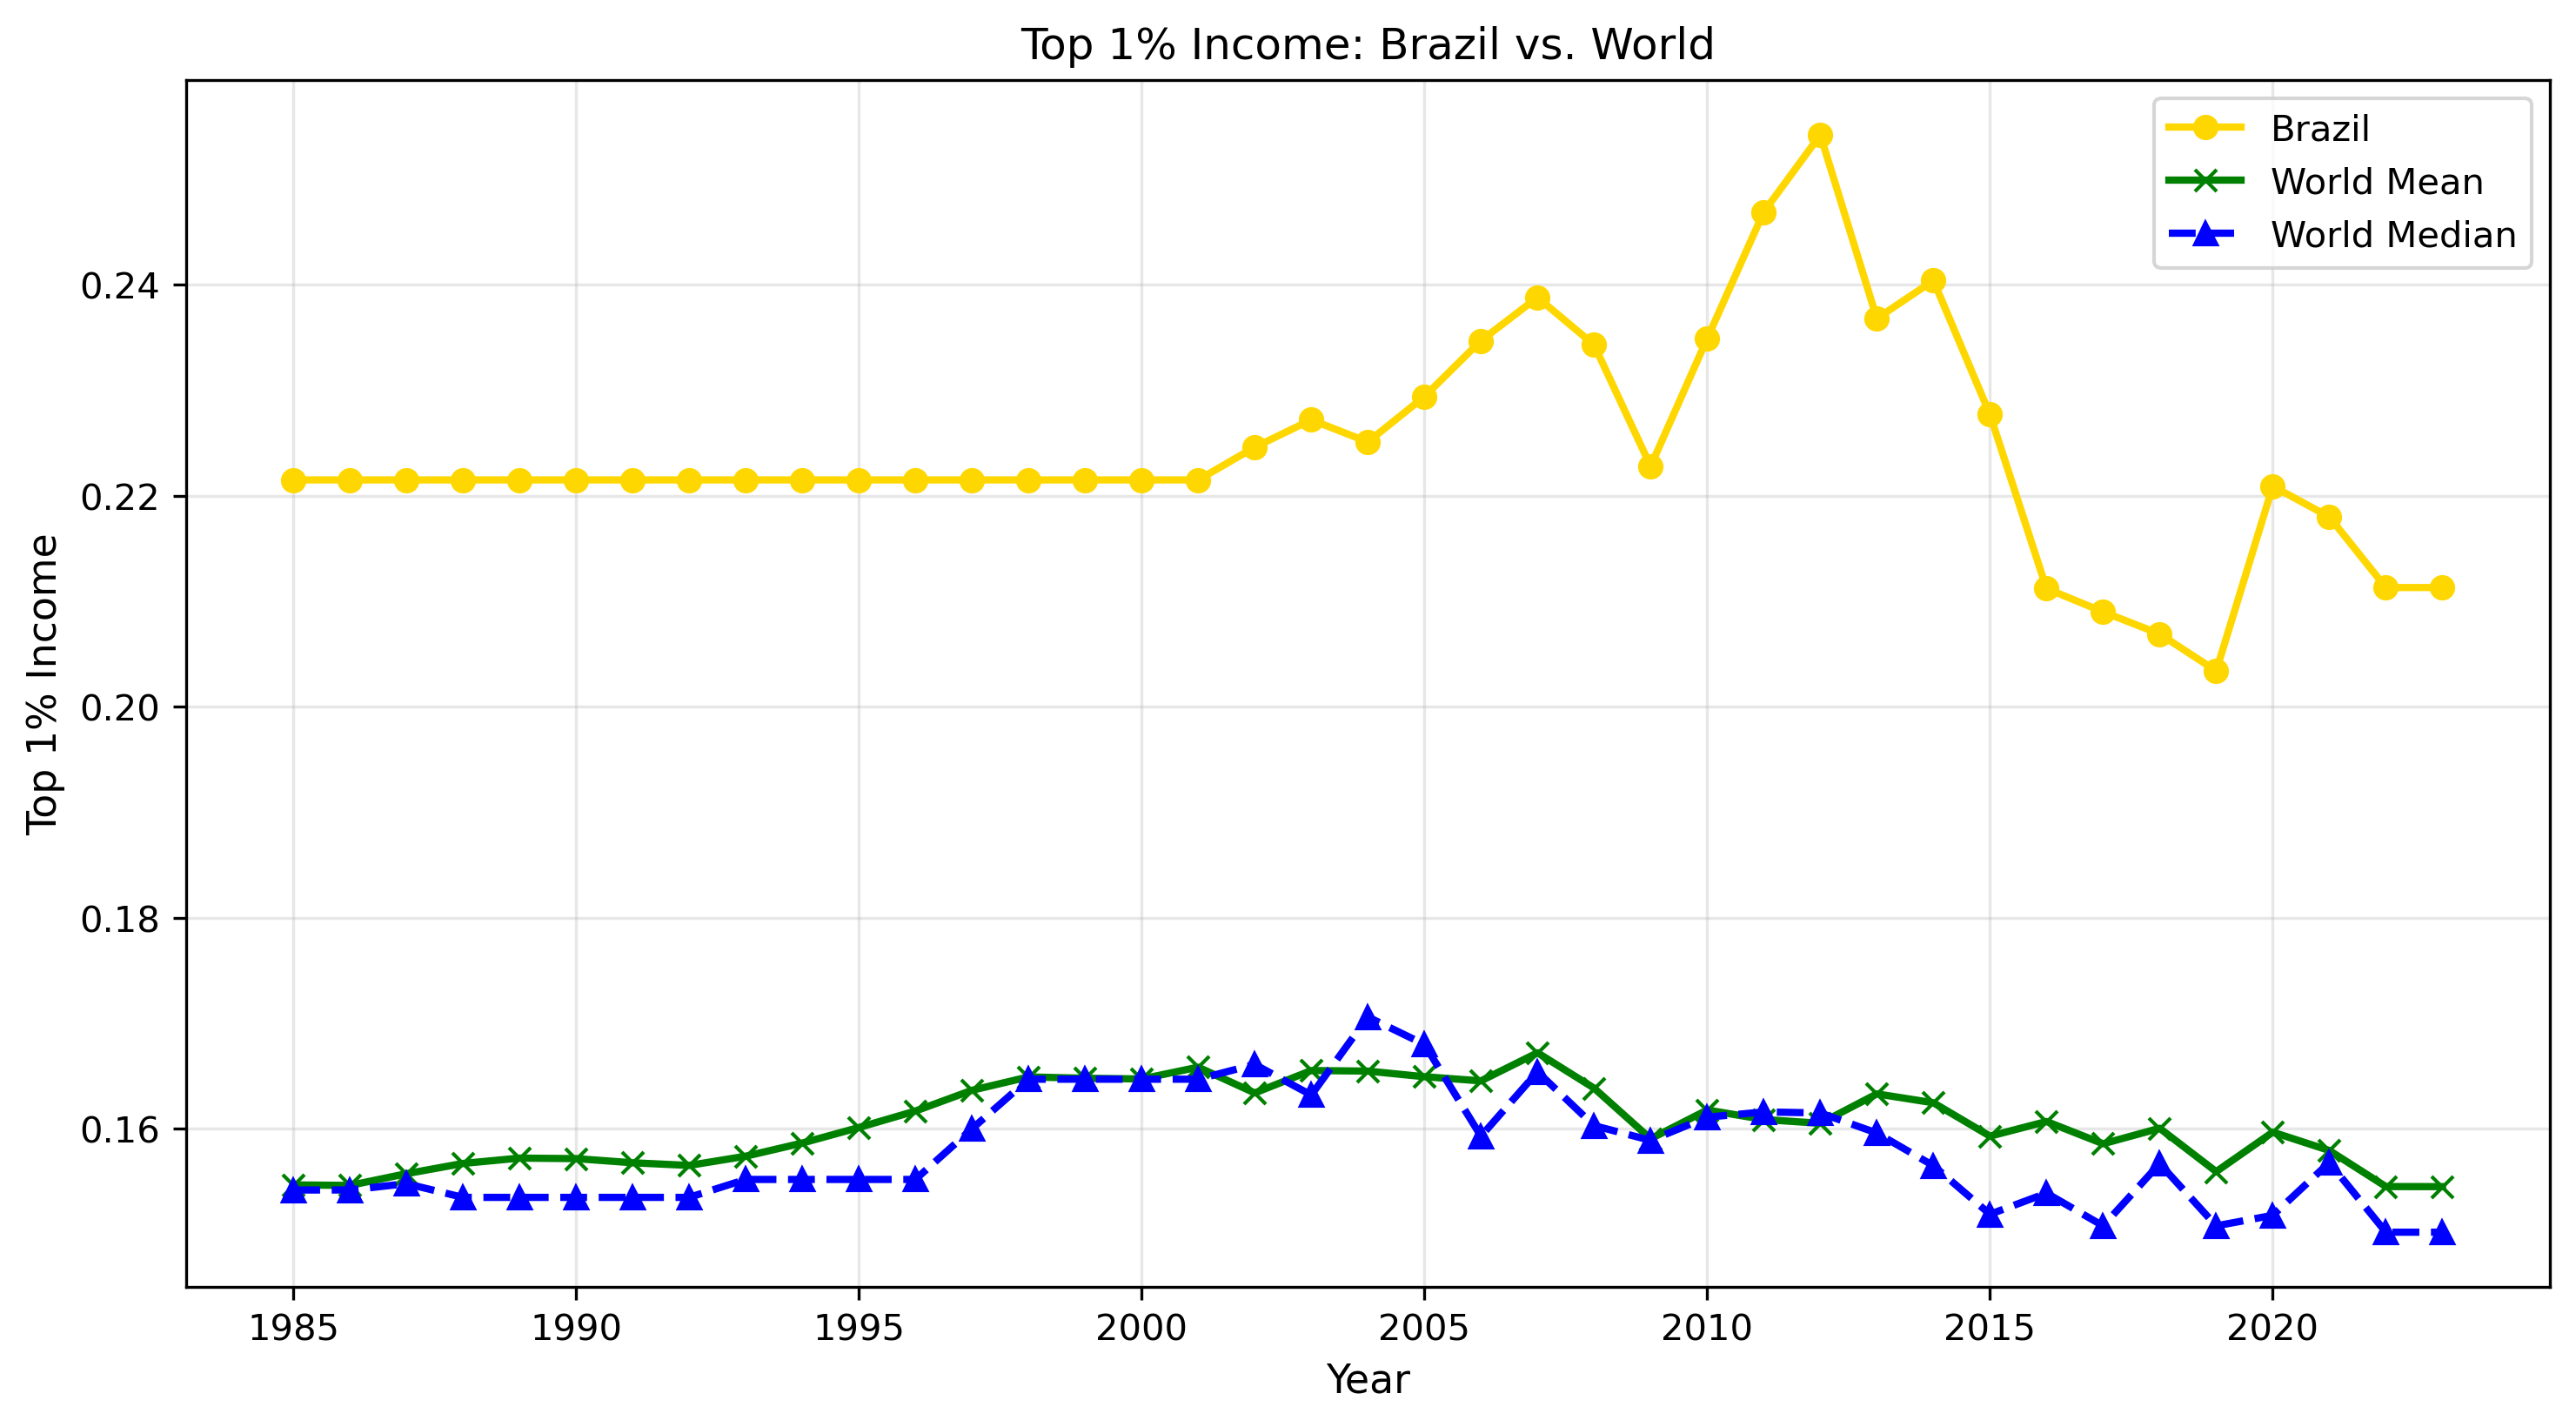

In [1089]:
years = list(range(1980, 2023))

world_mean = df.groupby('Year')['top1_inc'].mean()
world_median = df.groupby('Year')['top1_inc'].median()
brazil_data = df[df['Country Name'] == 'Brazil'].set_index('Year')['top1_inc']

fig, ax = plt.subplots(figsize=(10, 5.6))
ax.plot(brazil_data.index, brazil_data.values, marker='o', label='Brazil', color="gold", linewidth=2)
ax.plot(world_mean.index, world_mean.values, marker='x', label='World Mean', color="green", linewidth=2)
ax.plot(world_median.index, world_median.values, marker='^', label='World Median', linestyle='--', color="blue", linewidth=2)

ax.set_title('Top 1% Income: Brazil vs. World')
ax.set_xlabel('Year')
ax.set_ylabel('Top 1% Income')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()

fig.savefig("brazil_world_top1.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()
plt.close(fig)

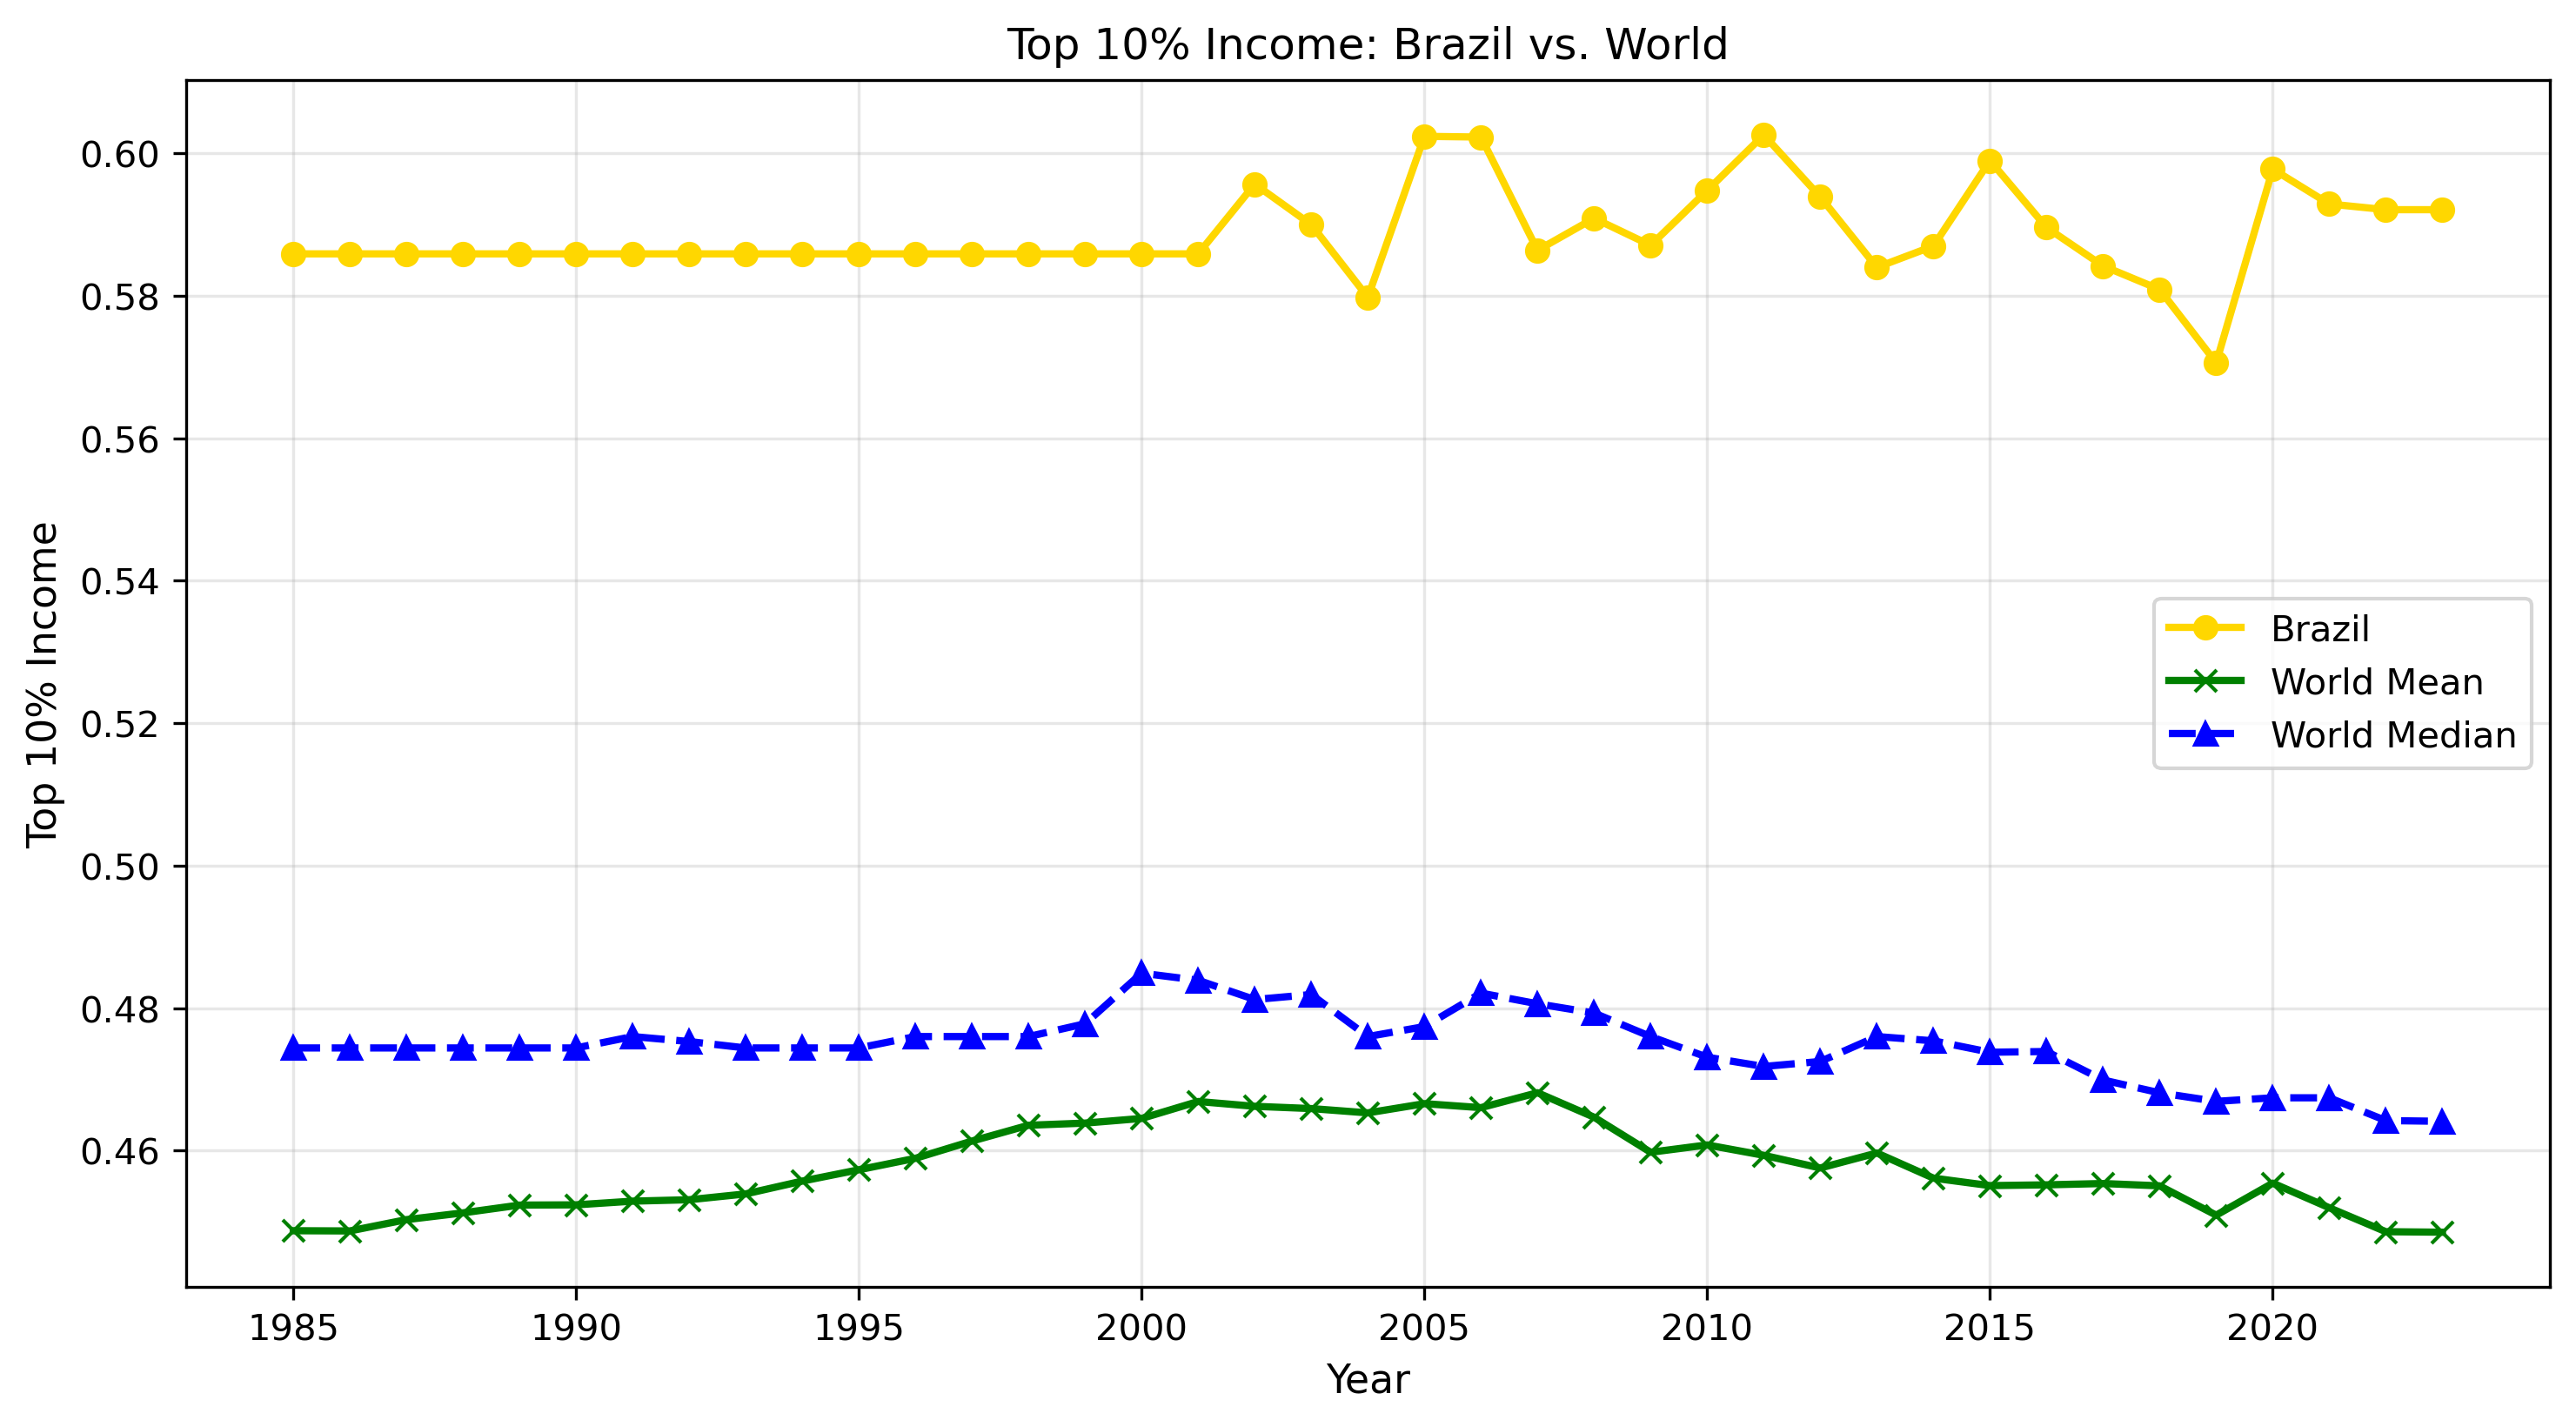

In [1091]:
years = list(range(1980, 2023))

world_mean = df.groupby('Year')['top10_inc'].mean()
world_median = df.groupby('Year')['top10_inc'].median()
brazil_data = df[df['Country Name'] == 'Brazil'].set_index('Year')['top10_inc']

fig, ax = plt.subplots(figsize=(10, 5.6))
ax.plot(brazil_data.index, brazil_data.values, marker='o', label='Brazil', color="gold", linewidth=2)
ax.plot(world_mean.index, world_mean.values, marker='x', label='World Mean', color="green", linewidth=2)
ax.plot(world_median.index, world_median.values, marker='^', label='World Median', linestyle='--', color="blue", linewidth=2)

ax.set_title('Top 10% Income: Brazil vs. World')
ax.set_xlabel('Year')
ax.set_ylabel('Top 10% Income')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()

fig.savefig("brazil_world_top10.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()
plt.close(fig)

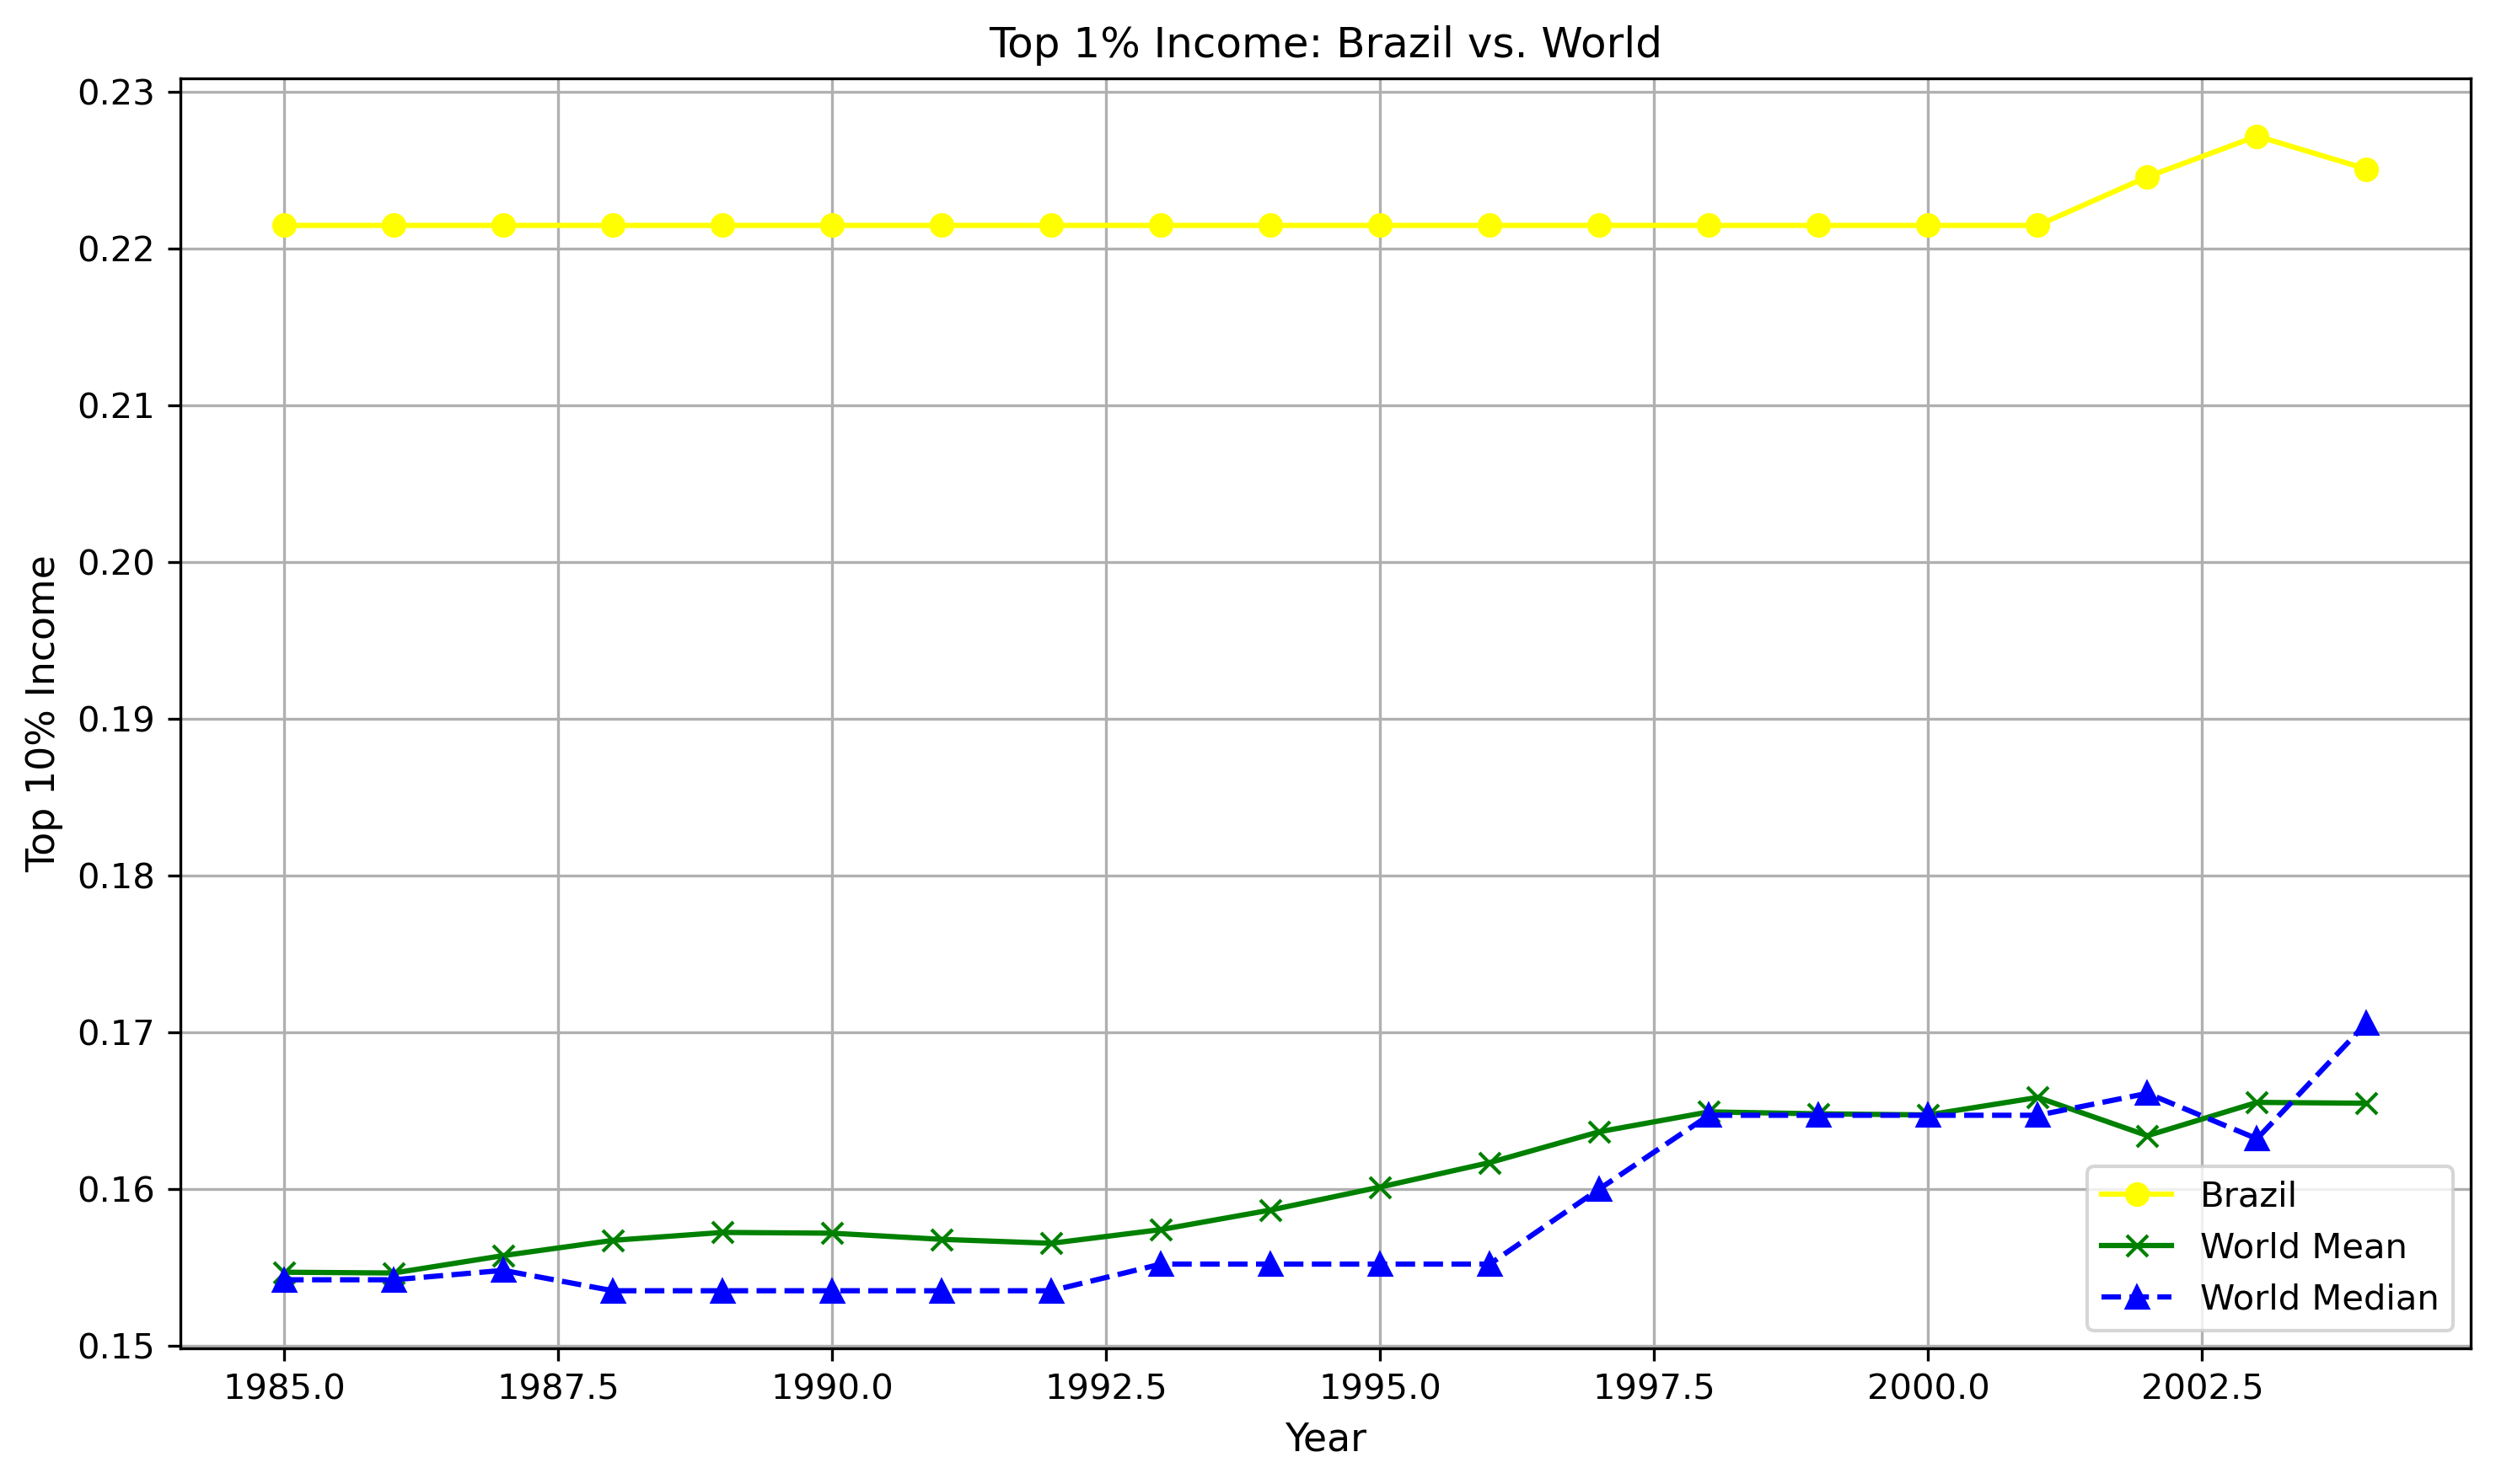

In [1093]:
years = list(range(1980, 2005))

world_mean = df.groupby('Year')['top1_inc'].mean().reindex(years)

world_median = df.groupby('Year')['top1_inc'].median().reindex(years)

brazil_data = df[df['Country Name'] == 'Brazil'].set_index('Year')['top1_inc'].reindex(years)

plt.figure(figsize=(10, 6))
plt.plot(brazil_data.index, brazil_data.values, marker='o', label='Brazil', color="yellow")
plt.plot(world_mean.index, world_mean.values, marker='x', label='World Mean',color="green")
plt.plot(world_median.index, world_median.values, marker='^', label='World Median', linestyle='--',color="blue")

plt.title('Top 1% Income: Brazil vs. World')
plt.xlabel('Year')
plt.ylabel('Top 10% Income')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

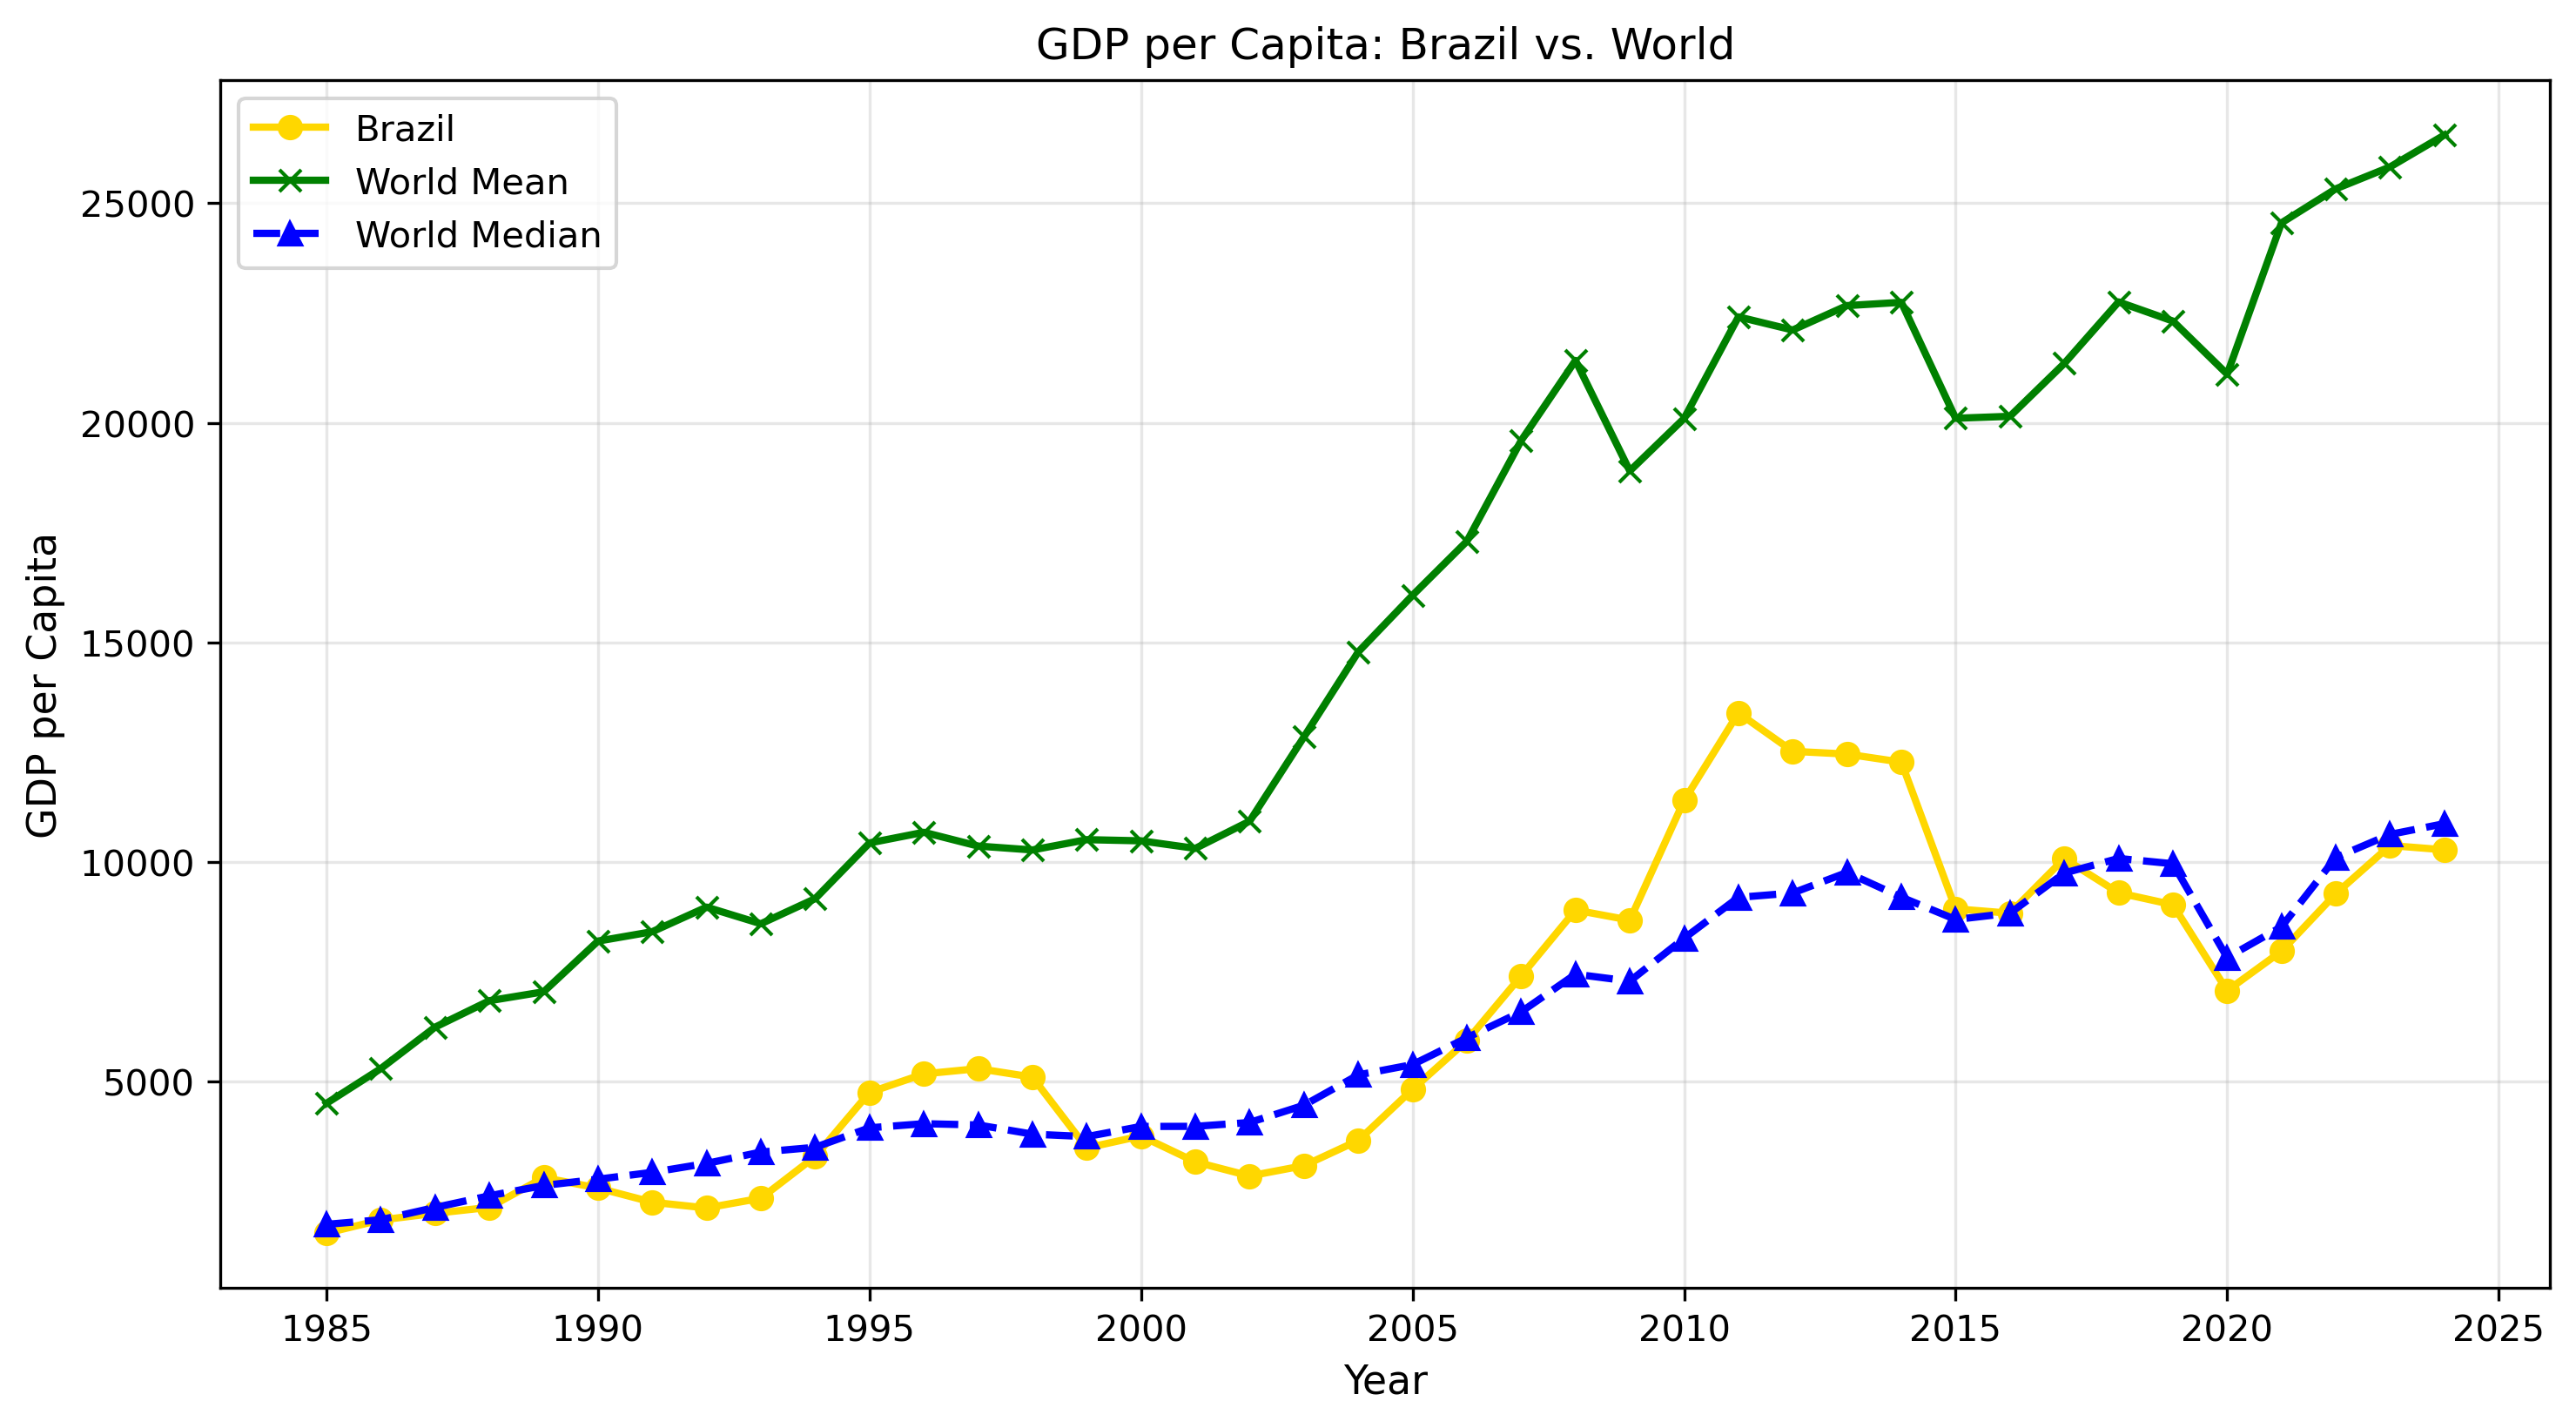

In [1095]:
years = list(range(1980, 2023))

world_mean = df.groupby('Year')['gdp_per_cap'].mean()
world_median = df.groupby('Year')['gdp_per_cap'].median()
brazil_data = df[df['Country Name'] == 'Brazil'].set_index('Year')['gdp_per_cap']

fig, ax = plt.subplots(figsize=(10, 5.6))
ax.plot(brazil_data.index, brazil_data.values, marker='o', label='Brazil', color="gold", linewidth=2)
ax.plot(world_mean.index, world_mean.values, marker='x', label='World Mean', color="green", linewidth=2)
ax.plot(world_median.index, world_median.values, marker='^', label='World Median', linestyle='--', color="blue", linewidth=2)

ax.set_title('GDP per Capita: Brazil vs. World')
ax.set_xlabel('Year')
ax.set_ylabel('GDP per Capita')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()

fig.savefig("brazil_world_gdp_pc.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()
plt.close(fig)

In [ ]:
from linearmodels.panel import PanelOLS

df.columns = df.columns.str.strip()
if df.index.names != ["Country Name","Year"]:
    df = df.set_index(["Country Name","Year"])

df["gdp_k"] = pd.to_numeric(df["gdp_per_cap"], errors="coerce") / 1000.0
df["gdp_k_sq"] = df["gdp_k"] ** 2
df["ln_top1"] = np.log(df["top1_inc"])
df["inflation"] = pd.to_numeric(df["inflation"], errors="coerce")
df["top1_inc"] = pd.to_numeric(df["top1_inc"], errors="coerce")

df_mod = df.dropna(subset=["top1_inc","inflation","gdp_k","gdp_k_sq"]).copy()

mod = PanelOLS.from_formula(
    "ln_top1 ~ inflation + gdp_k + gdp_k_sq + EntityEffects + TimeEffects",
    data=df_mod
).fit(cov_type="clustered", cluster_entity=True)

print(mod.summary)

b1 = mod.params["gdp_k"]
b2 = mod.params["gdp_k_sq"]
turn_k = -b1 / (2 * b2)
out_path = "/Users/lucasdubois/Desktop/MASTERDATA/kuznets_fe_results.tex"
latex_table = res.summary.as_latex()

with open("kuznets_fe_results.tex", "w") as f:
    f.write(latex_table)